# Climate Change in My Neck of the Woods?

I thought it might be interesting to explore what's happening in my local area in terms of climate change. The data fromm my local NOAA Weather station is somewhat limited and only goes back as far as 1195, but that may still be enough to find something interesting. 

I'll start by importing the data, which I ordered using the data ordering tool on [NOAA's site](https://www.ncdc.noaa.gov).

In [97]:
import pandas as pd

df = pd.read_csv('gray-weather.csv')
df.sample(5)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06
7129,USC00173295,"GRAY, ME US",2015-04-08,0.09,1.1,6.0,43.0,26.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
4256,USC00173295,"GRAY, ME US",2007-05-27,0.01,0.0,0.0,69.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7547,USC00173295,"GRAY, ME US",2016-05-30,0.04,0.0,0.0,71.0,49.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN
6378,USC00173295,"GRAY, ME US",2013-03-18,0.00,0.0,2.0,35.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4399,USC00173295,"GRAY, ME US",2007-10-17,0.00,0.0,0.0,63.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like we have a lot of null values, but that's OK. I can work with the Min and Max temps, and precipitation totals. 

Of course, we need to do a bit of cleaning first. A quick investidation with `df.dtypes` showed that the numbers are already floats, but the dates are stored as strings, so a good first step will be to convert them to datetime objects and then make a new monthly column so we can analyze by month if we want to. 

In [98]:
# convert to datetime object
df['DATE'] = pd.to_datetime(df['DATE'])
# create a new column with heading YYYY-MM that includes only year and month
df['YYYY-MM'] = pd.to_datetime(df['DATE']).dt.strftime('%Y-%m')

Now let's make a new dataframe with only the columns I actually want, just to make it easier to look at.

In [99]:
gray = df[['DATE', 'YYYY-MM', 'PRCP', 'TMAX', 'TMIN']]
gray.sample(3)

,DATE,YYYY-MM,PRCP,TMAX,TMIN
5166,2009-11-22,2009-11,0.00,47.0,32.0
650,1997-07-12,1997-07,0.00,86.0,65.0
2993,2003-12-11,2003-12,1.41,49.0,28.0


Let's do some quick exploratory data viz to see if that reveals anything.

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

Since I'll be doing a bunch of plotting of the same basic form, I'll start by writing a little function to generate individual plots more quickly.

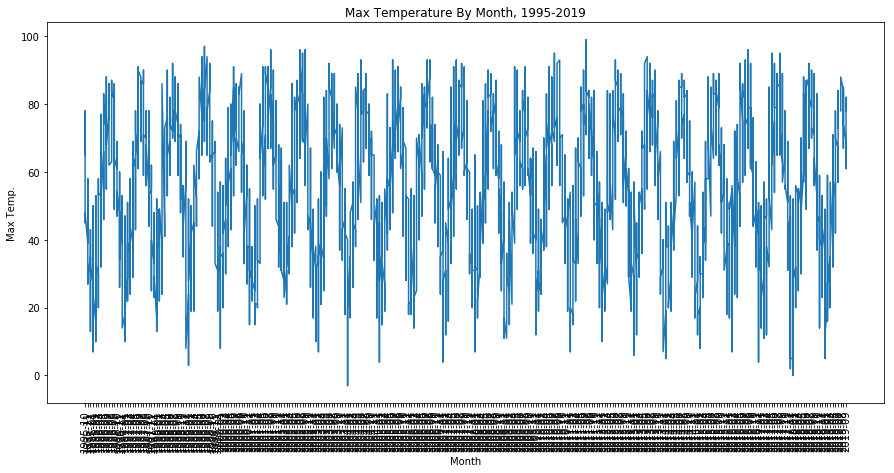

In [101]:
def plot_charts(x_axis, x_label, y_axis, y_label, plot_title):
    fig = plt.figure(figsize=(15,7))
    plt.plot(x_axis, y_axis)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title + ', 1995-2019')
    plt.xticks(rotation=90)
#     plt.locator_params(axis='x', nticks=10)
    plt.show()
    
plot_charts(gray['YYYY-MM'], 'Month', gray['TMAX'], 'Max Temp.', 'Max Temperature By Month')

I haven't yet figured out how to reduce the x label counts in a meaningful way, but this will work OK for now and I can come back to improve that function later. For now, though, looking at this daily data isn't showing much. Let's try breaking it down to a monthly average and then plotting those.

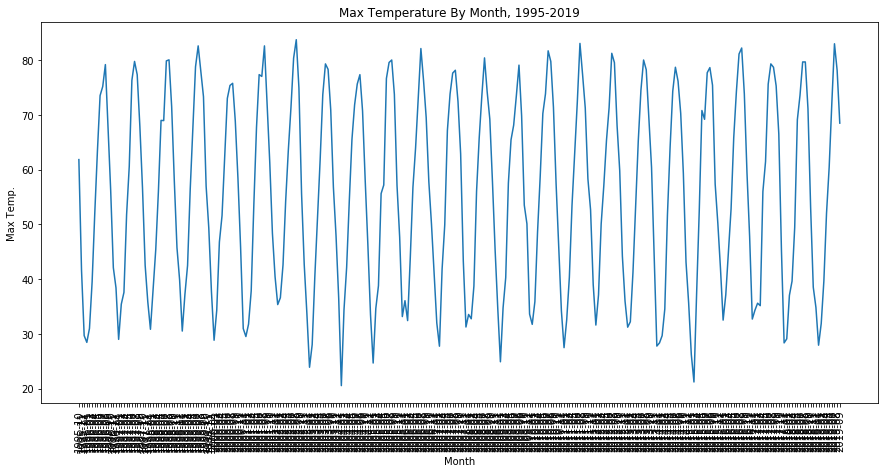

In [102]:
monthly_tmax_avg = gray[['YYYY-MM','TMAX']]
tmx_avg = monthly_tmax_avg.groupby(monthly_tmax_avg['YYYY-MM']).mean()
tmx_avg = tmx_avg.reset_index() # to turn dates back into a column instead of the index
                                # so that we can use the plotting function we made
plot_charts(tmx_avg['YYYY-MM'], 'Month', tmx_avg['TMAX'], 'Max Temp.', 'Max Temperature By Month')

Of course this isn't very useful either because of the seasonal fluctuations. What we really need to do is compare the months to each other. Let's go back to the full data set and add a month column, which we can then use for some boolean sorting hopefully.

In [103]:
gray = gray.set_index('DATE')  # need to make dates the index again
gray['MM'] = gray.index.month

Great, now we can filter for months and start doing some charting based on that. 

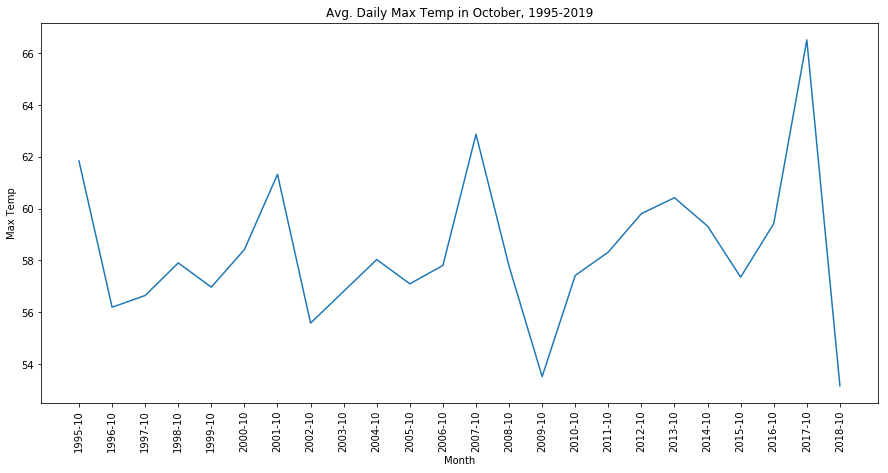

In [110]:
#create a new function that takes the month you want to filter for as an integer argument
def month_bool(month, month_title, sorter, chart_title):     
    month_bool = (gray['MM'] == month)  # create a boolean to filter for a given month
    month_ds = gray[month_bool] # create variable that's a new df filtered by our boolean mask
    month_ds = month_ds[['YYYY-MM', sorter]] # make df with just what we want to plot
    month_ds_avg = month_ds.groupby(month_ds['YYYY-MM']).mean() #groupby month and get mean
    month_ds_avg = month_ds_avg.reset_index()
    plot_charts(month_ds_avg['YYYY-MM'], 'Month', month_ds_avg[sorter], chart_title, 
                'Avg. Daily ' + chart_title + ' in ' + month_title)

month_bool(10, 'October', 'TMAX', 'Max Temp')

That's interesting. Not much of a clear trend for the month of October, although average max temperature may not be a great metric, and since the data only goes back to 1995 it's not a super large data set. Let's try running some other stuff through this function.

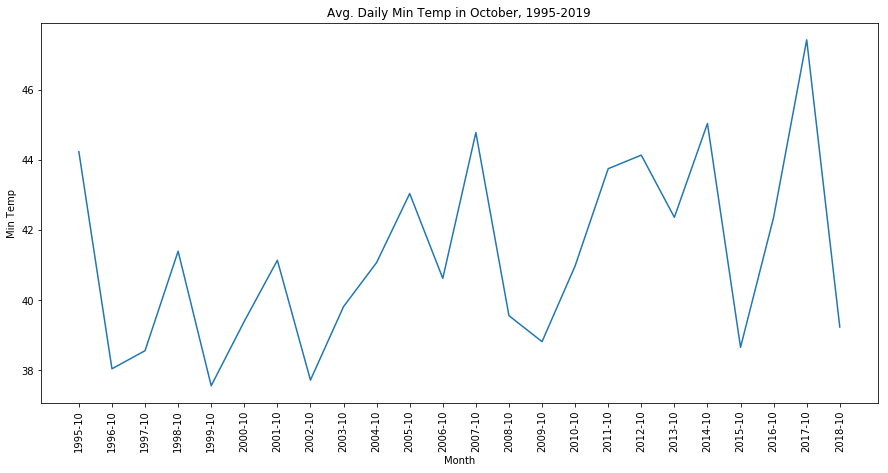

In [111]:
month_bool(10, 'October', 'TMIN', 'Min Temp')

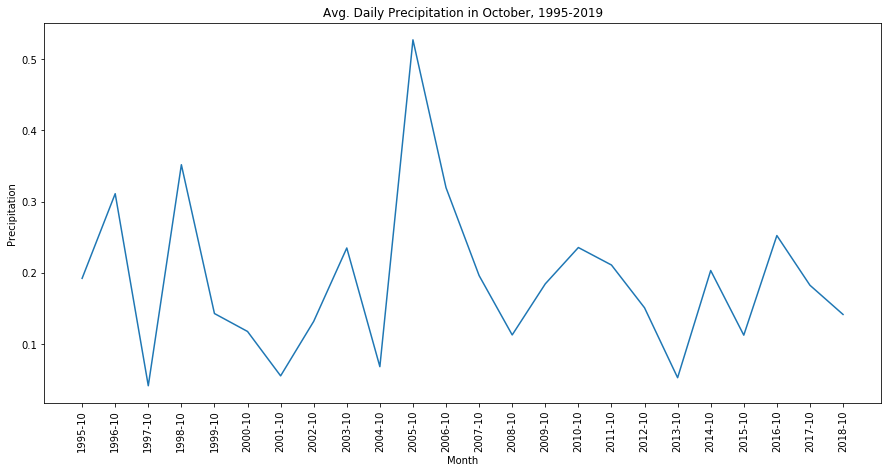

In [112]:
month_bool(10, 'October', 'PRCP', 'Precipitation')

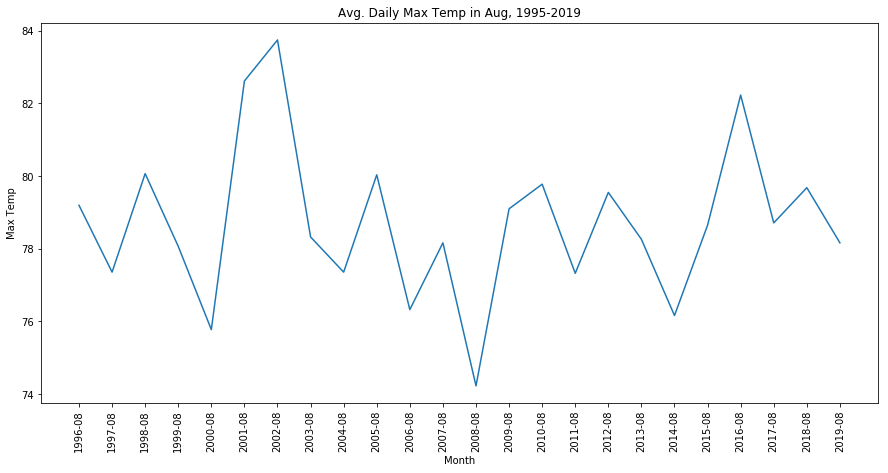

In [113]:
month_bool(8, 'Aug', 'TMAX', 'Max Temp')

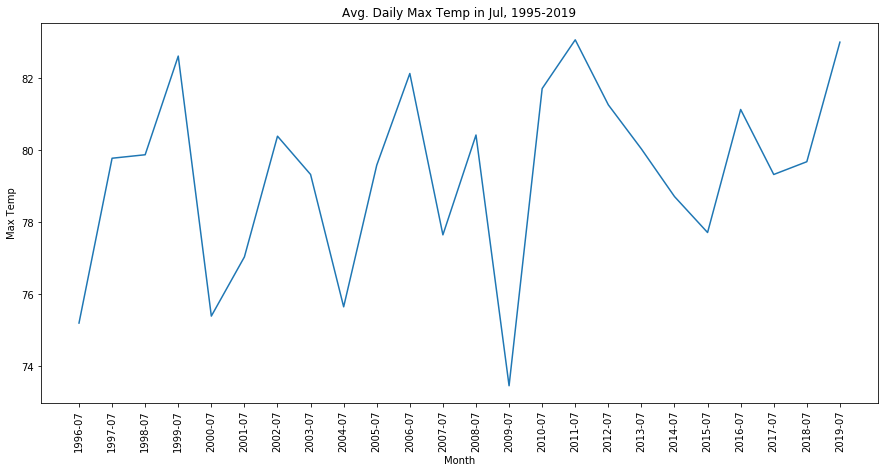

In [114]:
month_bool(7, 'Jul', 'TMAX', 'Max Temp')

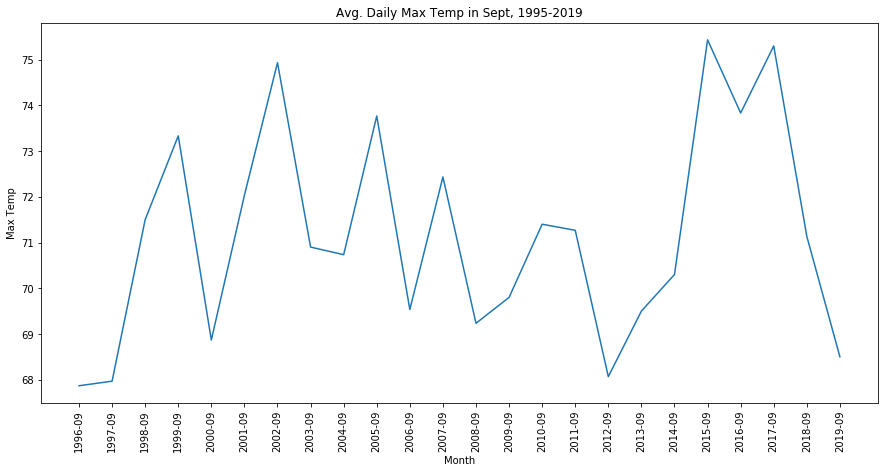

In [115]:
month_bool(9, 'Sept', 'TMAX', 'Max Temp')

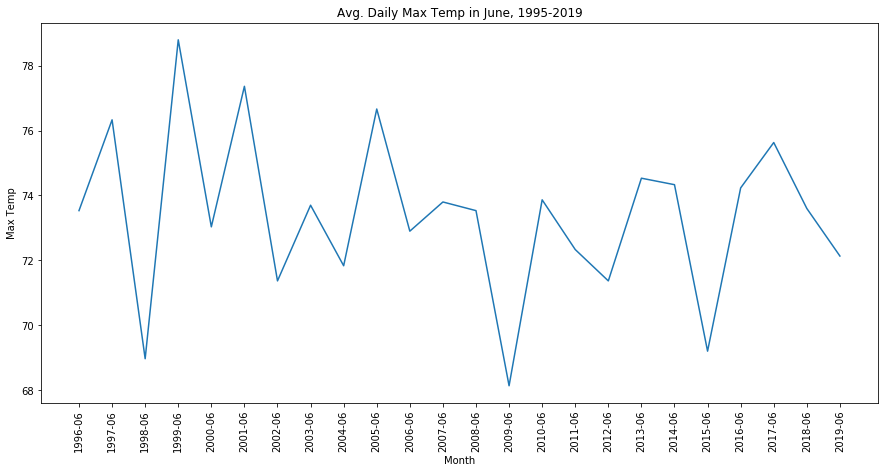

In [116]:
month_bool(6, 'June', 'TMAX', 'Max Temp')

Interesting. In a few months there does seem to be a pretty clear uptick (July, Sept.), whereas in others there's not much evidence of anything. Probably not a huge shock given the limited timescale. It may also be worth investigating if median is more meaingful than mean here, given how the mean could be thrown off pretty easily by one or two outlier days. Let's try that!

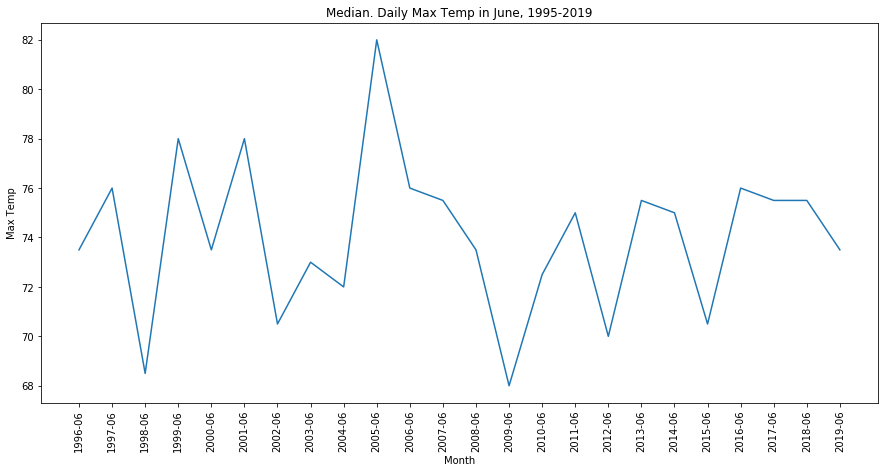

In [118]:
def med_month_bool(month, month_title, sorter, chart_title):     
    month_bool = (gray['MM'] == month)  # create a boolean to filter for a given month
    month_ds = gray[month_bool] # create variable that's a new df filtered by our boolean mask
    month_ds = month_ds[['YYYY-MM', sorter]] # make df with just what we want to plot
    month_ds_avg = month_ds.groupby(month_ds['YYYY-MM']).median() #groupby month and get mean
    month_ds_avg = month_ds_avg.reset_index()
    plot_charts(month_ds_avg['YYYY-MM'], 'Month', month_ds_avg[sorter], chart_title, 
                'Median. Daily ' + chart_title + ' in ' + month_title)
    
med_month_bool(6, 'June', 'TMAX', 'Max Temp')

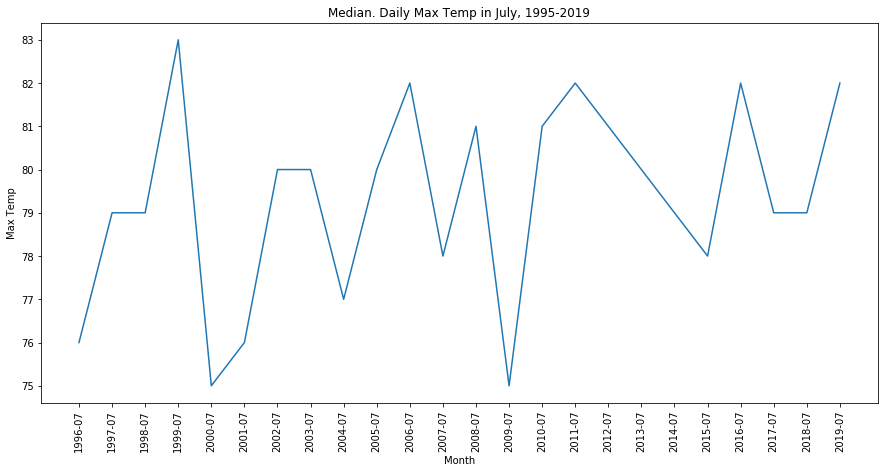

In [119]:
med_month_bool(7, 'July', 'TMAX', 'Max Temp')

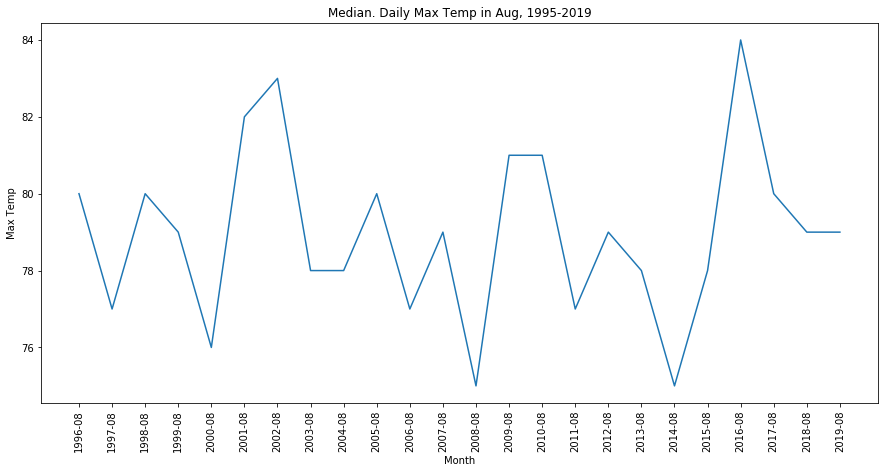

In [120]:
med_month_bool(8, 'Aug', 'TMAX', 'Max Temp')

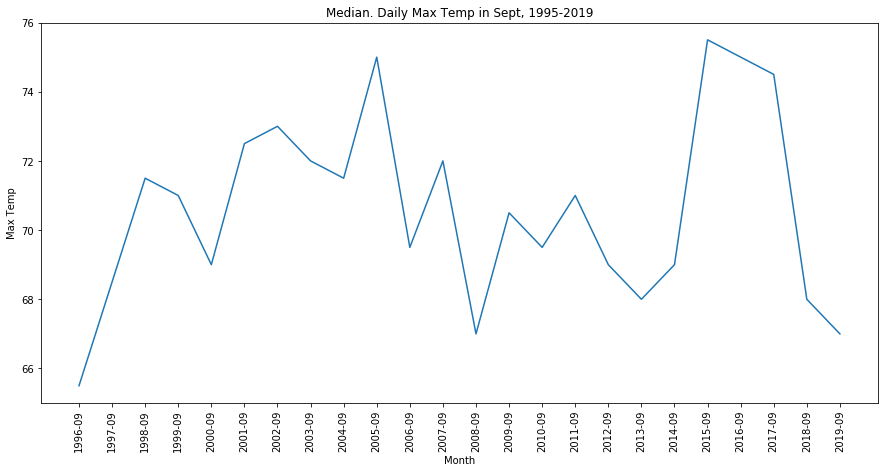

In [121]:
med_month_bool(9, 'Sept', 'TMAX', 'Max Temp')

Interesting, although the more I look at these, the more I suspect this is a wildly insufficient form of analysis, and a dataset that's too small. If I had to draw any conclusion, I'd say that even in the context of this small and very limted data set (one location, less than 30 years of data), it does seem like temperatures are warming, at least in the late summer. 

Looking at median temps, July, August and September all seem to be seeing _some_ level of recent rise, though whether it's statistically significant is beyond me. (September's 2019 number is low, but we're in the middle of a heat wave so I doubt it'll stay that way when the month is over). And the trend is weak enough that it's possible I'm just seeing what I want to see here. This is where statistics training would come in handy, if I had any. 

Still, we're here, so let's look at some min temps for the winter:

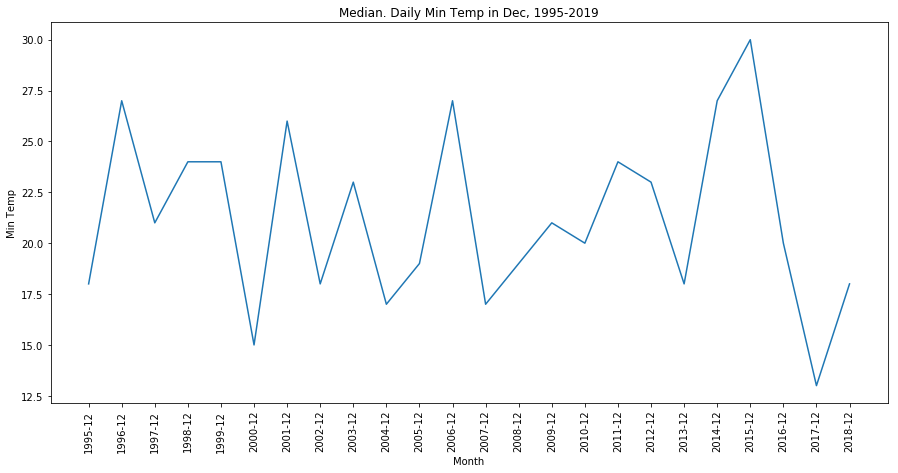

In [123]:
med_month_bool(12, 'Dec', 'TMIN', 'Min Temp')

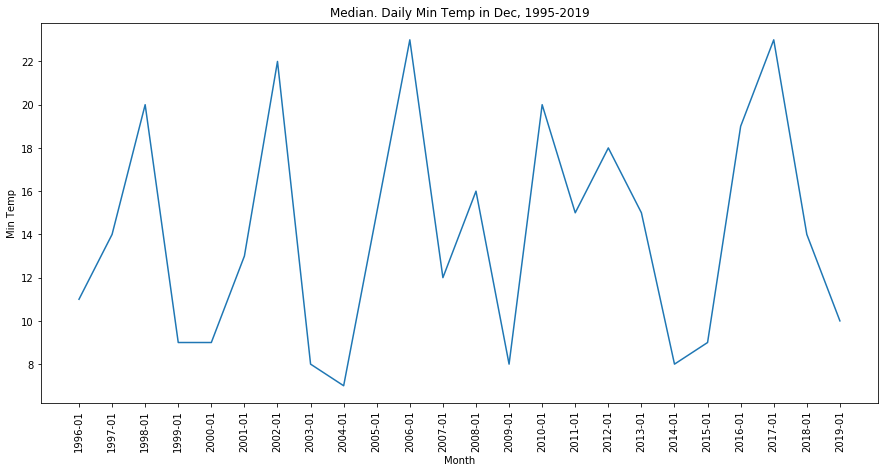

In [124]:
med_month_bool(1, 'Dec', 'TMIN', 'Min Temp')

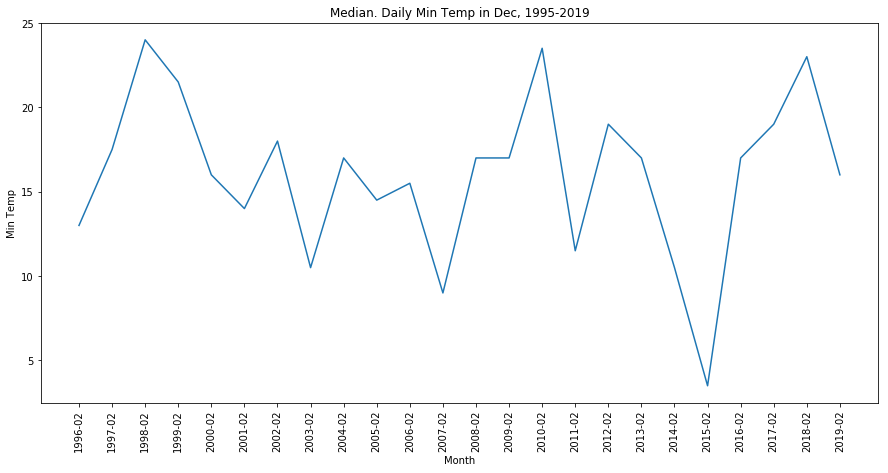

In [125]:
med_month_bool(2, 'Dec', 'TMIN', 'Min Temp')

Not seeing much of a pattern there. Going to leave off here for now. Potential future expansions:
* Prettify graphs, bar charts
* Add a trend line (learn some basic linear regression?)
* Take a different sort of look at precipitation, maybe sum total per month and/or per year.